### PyTorch Torchvision: Training Faster R-CNN Object Detection with ResNet50 and FPN


Step-by-step guide on how to train a Faster R-CNN object detection model using the ResNet50 backbone and Feature Pyramid Network (FPN) with PyTorch and torchvision. ResNet50 is used as the backbone to extract features from images, and FPN enhances the scale-invariance of these features.

In [1]:
# import necessary libraries
import io
import os
import random
import copy
import torch
import onnx
import sys
import warnings
import mlflow
import mlflow.pytorch
from PIL import Image
import seaborn as sn
import pandas as pd
from pathlib import Path
import json
import gc
import torchinfo
import torchvision
import numpy as np
import tensorrt as trt
import openvino as ov
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2
from pycocotools.coco import COCO
from typing import Any, Tuple, List, Dict
from torchvision.ops.boxes import box_convert
from contextlib import redirect_stdout
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from openvino.runtime import Core
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_V2_Weights, fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from pycocotools.cocoeval import COCOeval
import onnxruntime as ort
from torchvision.transforms import ToPILImage
from collections import OrderedDict
from torchvision.models.detection.roi_heads import fastrcnn_loss
from torchvision.models.detection.rpn import concat_box_prediction_layers
from datetime import datetime
from torchvision import tv_tensors
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Subset, random_split
from torchvision.ops import nms

In [2]:
# check basic information of cuda and cudnn
print("torch.backends.cuda.matmul.allow_tf32: " + str(torch.backends.cuda.matmul.allow_tf32))
print("torch.backends.cudnn.allow_tf32: "  + str(torch.backends.cudnn.allow_tf32))

torch.backends.cuda.matmul.allow_tf32: False
torch.backends.cudnn.allow_tf32: True


In [3]:
# implement functions for basic usage
def collate_fn(batch):
    """
    This function takes a batch of data and returns a tuple of zipped data.
    It is often used in PyTorch data loaders to collate multiple data samples into batches.
    """
    return tuple(zip(*batch))

def image_visualization(img):
    """
    This function takes an image tensor, permutes the dimensions to make it suitable for visualization (channels last),
    converts it to a numpy array, and then uses matplotlib's imshow function to display the image.
    """
    image_array = img.permute(1, 2, 0).numpy()

    plt.figure(figsize = (10, 10))
    plt.imshow(image_array)
    plt.axis('off')

    plt.show()

def image_visualization_with_annotation(img, segs, labs, category_mapping, format):
    """
    This function is similar to image_visualization, but it also takes a list of segments (annotations).
    Each segment is a rectangle defined by its top-left corner coordinates and its width and height.
    The function draws these rectangles on the image using matplotlib's patches.Rectangle and displays the annotated image.
    The rectangles are drawn with a red border and no fill color.
    """
    image_array = img.permute(1, 2, 0).numpy()

    plt.figure(figsize = (10, 10))
    plt.imshow(image_array)

    for seg, lab in zip(segs, labs):
        if format == 'xywh':
            rect = patches.Rectangle((seg[0], seg[1]), seg[2], seg[3], linewidth = 1, edgecolor = 'r', facecolor = 'none')
            plt.gca().add_patch(rect)

            # add the label at the top-left corner of the rectangle
            plt.text(seg[0], seg[1], category_mapping[lab.item()], color = 'red', fontsize = 9, 
                bbox = dict(facecolor = 'none', edgecolor = 'none')
            )
        elif format == 'xyxy':
            # calculate width and height from the coordinates
            width = seg[2] - seg[0]
            height = seg[3] - seg[1]

            rect = patches.Rectangle((seg[0], seg[1]), width, height, linewidth = 1, edgecolor = 'r', facecolor = 'none')
            plt.gca().add_patch(rect)

            # add the label at the top-left corner of the rectangle
            plt.text(seg[0], seg[1], category_mapping[lab.item()], color = 'red', fontsize = 9, 
                bbox = dict(facecolor = 'none', edgecolor = 'none')
            )

    plt.axis('off')
    plt.show()

def convert_to_xywh(boxes):
    """
    Converts bounding boxes from (xmin, ymin, xmax, ymax) format to (x, y, width, height) format.

    Parameters:
    boxes (Tensor): A tensor containing bounding boxes in (xmin, ymin, xmax, ymax) format.

    Returns:
    Tensor: A tensor containing bounding boxes in (x, y, width, height) format.
    """
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim = 1)

def prepare_for_coco_detection(predictions):
    """
    Prepares the predictions for COCO detection by converting the bounding boxes to (x, y, width, height) format 
    and packaging the results in a list of dictionaries.

    Parameters:
    predictions (dict): A dictionary containing the predictions.

    Returns:
    list: A list of dictionaries, each containing an image id, category id, bounding box, and score.
    """
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

def get_iou_types(model):
    """
    Determines the Intersection over Union (IoU) types based on the type of the model.

    Parameters:
    model (torchvision.models.detection): The detection model.

    Returns:
    list: A list of IoU types.
    """
    iou_types = ["bbox"]
    if isinstance(model, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

def evaluate(imgs):
    """
    Evaluates the images and returns the image IDs and evaluation images reshaped to the correct dimensions.

    Parameters:
    imgs (COCO): The COCO formatted images to be evaluated.

    Returns:
    tuple: A tuple containing the image IDs and evaluation images reshaped to the correct dimensions.
    """
    with redirect_stdout(io.StringIO()):
        imgs.evaluate()
    return imgs.params.imgIds, np.asarray(imgs.evalImgs).reshape(-1, len(imgs.params.areaRng), len(imgs.params.imgIds))

def model_summary(model, device):
    """
    This function prints a summary of the given PyTorch model. The summary includes the names and shapes of the model's 
    layers and parameters, as well as the total number of parameters.

    Parameters:
    model (torch.nn.Module): The PyTorch model to summarize.
    device (torch.device): The device (CPU or GPU) where the model is located.

    The function uses a fixed input size for the summary, which is a batch of 4 images of size 640x640 with 3 color channels.
    """
    batch_size = 1
    channels = 3
    img_height = 640
    img_width = 640

    return torchinfo.summary(
        model,
        device = device,
        input_size = [batch_size, channels, img_height, img_width],
        row_settings = ["var_names"]
    )

def select_and_view_random_image(target_dir, target_class):
    """
    Selects a random image from a specified directory and displays it.

    Parameters:
    target_dir (str): The base directory where the images are stored.
    target_class (str): The subdirectory within the base directory where the images are stored.

    Returns:
    img (numpy.ndarray): The selected image as a numpy array.
    """
    target_folder = target_dir + target_class
    image_files = [f for f in os.listdir(target_folder) if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg')]
    random_image = random.sample(image_files, 1)

    img = mpimg.imread(target_folder + "/" + random_image[0])

    plt.imshow(img)
    plt.axis("off")

    print(f"Image shape: {img.shape}")

    return img

def visualize_output(tensor_image, output, threshold = 0.1):
    """
    Visualizes the output of a model on an image. The output is expected to contain bounding boxes, labels, and scores.

    Parameters:
    tensor_image (torch.Tensor): The input image as a tensor.
    output (dict): The output from the model. Expected to be a dictionary with keys 'boxes', 'labels', and 'scores'.
    threshold (float, optional): The score threshold for displaying bounding boxes. Boxes with scores below this threshold will not be displayed. Default is 0.1.

    Returns:
    None. This function displays a plot but does not return anything.
    """
    # convert the tensor image back to PIL Image
    image = (tensor_image.cpu().squeeze(0) * 255)
    pil_image = ToPILImage()(image)

    fig, ax = plt.subplots()
    ax.imshow(pil_image)

    boxes = output[0]['boxes']
    labels = output[0]['labels']
    scores = output[0]['scores']

    for box, label, score in zip(boxes, labels, scores):
      rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], 
        linewidth = 1, edgecolor = 'r', facecolor = 'none')
      ax.add_patch(rect)
      plt.text(box[0], box[1], f'{label}: {score:.2f}', color = 'r')

    plt.axis('off')
    plt.show()

def plot_loss_curve(result: Dict[str, List[float]], dir_name: str):
    """
    This function plots the training and validation losses for a model over the number of epochs.

    Parameters:
    result (Dict[str, List[float]]): A dictionary containing lists of loss values. The keys are strings indicating the type of loss (e.g., 'total_train_loss', 'total_train_loss_classifier', etc.) and the values are lists of floats representing the loss values over the epochs.

    The function creates a 2x3 grid of subplots. For each type of loss, it plots the training and validation losses over the epochs on a subplot. It sets the title of the subplot to the type of loss and the x-label to 'Epochs'. It also adds a legend to the top right corner of each subplot.

    The function does not return anything. It directly shows the plot using plt.show().
    """
    epochs = range(len(result['total_train_loss']))
    plt.figure(figsize = (15, 10))

    loss_types = ['total_train_loss', 'total_train_loss_classifier', 'total_train_loss_box_reg', 'total_train_loss_objectness', 'total_train_loss_rpn_box_reg']
    loss_titles = ['Loss', 'Loss Classifier', 'Loss Box Reg', 'Loss Objectness', 'Loss RPN Box Reg']

    for i, loss_type in enumerate(loss_types):
        plt.subplot(2, 3, i + 1)
        plt.plot(epochs, result[loss_type], label = 'train')
        plt.plot(epochs, result['total_val_' + loss_type.split('_train_')[1]], label = 'val')
        plt.title(loss_titles[i])
        plt.xlabel('Epochs')
        plt.legend(loc = 'upper right')

    os.mkdir('result/' + dir_name)
    plt.savefig(f'result/{dir_name}/loss_plot.png')

    with open(f'result/{dir_name}/data.json', 'w') as f:
        json.dump(result, f)

In [4]:
# functions and classes for evaluation
def box_iou(box1, box2, eps = 1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes. Both sets of boxes are expected to be in (x1, y1, x2, y2) format.

    Args:
        box1 (torch.Tensor): A tensor of shape (N, 4) representing N bounding boxes.
        box2 (torch.Tensor): A tensor of shape (M, 4) representing M bounding boxes.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): An NxM tensor containing the pairwise IoU values for every element in box1 and box2.
    """

    # inter(N, M) = (rb(N, M, 2) - lt(N, M, 2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # iou = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

def smooth(y, f = 0.05):
    """
    Apply box filter smoothing to array `y` with fraction `f`, yielding a smoothed array.
    """
    nf = round(len(y) * f * 2) // 2 + 1 # number of filter elements (must be odd)
    p = np.ones(nf // 2) # one padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0) # y padded

    return np.convolve(yp, np.ones(nf) / nf, mode = "valid") # y-smoothed

def compute_ap(recall, precision):
    """
    Compute the average precision, given the recall and precision curve.
    # Arguments
        recall: The recall curve (list)
        precision: The precision curve (list)
    # Returns
        Average precision, precision curve, recall curve
    """
    # append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # integrate area under curve
    method = "interp" # method: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101) # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x) # integrate
    else: # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0] # point where x axis (recall) change
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1]) # area under curve

    return ap, mpre, mrec

def ap_per_class(
    tp, conf, pred_cls, target_cls, plot = False, on_plot = None, save_dir = Path(), names = (),
    eps = 1e-16, prefix = ""
):
    """
    Computes the average precision per class for object detection evaluation.

    Args:
        tp (np.ndarray): Binary array indicating whether the detection is correct (True) or not (False).
        conf (np.ndarray): Array of confidence scores of the detections.
        pred_cls (np.ndarray): Array of predicted classes of the detections.
        target_cls (np.ndarray): Array of true classes of the detections.
        plot (bool, optional): Whether to plot PR curves or not. Defaults to False.
        on_plot (func, optional): A callback to pass plots path and data when they are rendered. Defaults to None.
        save_dir (Path, optional): Directory to save the PR curves. Defaults to an empty path.
        names (tuple, optional): Tuple of class names to plot PR curves. Defaults to an empty tuple.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-16.
        prefix (str, optional): A prefix string for saving the plot files. Defaults to an empty string.

    Returns:
        (tuple): A tuple of six arrays and one array of unique classes, where:
            tp (np.ndarray): True positive counts at threshold given by max F1 metric for each class.Shape: (nc,).
            fp (np.ndarray): False positive counts at threshold given by max F1 metric for each class. Shape: (nc,).
            p (np.ndarray): Precision values at threshold given by max F1 metric for each class. Shape: (nc,).
            r (np.ndarray): Recall values at threshold given by max F1 metric for each class. Shape: (nc,).
            f1 (np.ndarray): F1-score values at threshold given by max F1 metric for each class. Shape: (nc,).
            ap (np.ndarray): Average precision for each class at different IoU thresholds. Shape: (nc, 10).
            unique_classes (np.ndarray): An array of unique classes that have data. Shape: (nc,).
            p_curve (np.ndarray): Precision curves for each class. Shape: (nc, 1000).
            r_curve (np.ndarray): Recall curves for each class. Shape: (nc, 1000).
            f1_curve (np.ndarray): F1-score curves for each class. Shape: (nc, 1000).
            x (np.ndarray): X-axis values for the curves. Shape: (1000,).
            prec_values: Precision values at mAP@0.5 for each class. Shape: (nc, 1000).
    """

    # sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts = True)
    nc = unique_classes.shape[0] # number of classes, number of detections

    # create Precision-Recall curve and compute AP for each class
    x, prec_values = np.linspace(0, 1, 1000), []

    # average precision, precision and recall curves
    ap, p_curve, r_curve = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))

    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci] # number of labels
        n_p = i.sum() # number of predictions

        if n_p == 0 or n_l == 0:
            continue

        # accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)

        # recall
        recall = tpc / (n_l + eps) # recall curve
        r_curve[ci] = np.interp(-x, -conf[i], recall[:, 0], left = 0) # negative x, xp because xp decreases

        # precision
        precision = tpc / (tpc + fpc) # precision curve
        p_curve[ci] = np.interp(-x, -conf[i], precision[:, 0], left = 1) # p at pr_score

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                prec_values.append(np.interp(x, mrec, mpre)) # precision at mAP@0.5

    prec_values = np.array(prec_values) # (nc, 1000)

    # compute F1 (harmonic mean of precision and recall)
    f1_curve = 2 * p_curve * r_curve / (p_curve + r_curve + eps)
    names = [v for k, v in names.items() if k in unique_classes] # list: only classes that have data
    names = dict(enumerate(names)) # to dict

    if plot:
        plot_pr_curve(x, prec_values, ap, save_dir / f"{prefix}PR_curve.png", names)
        plot_mc_curve(x, f1_curve, save_dir / f"{prefix}F1_curve.png", names, ylabel = "F1")
        plot_mc_curve(x, p_curve, save_dir / f"{prefix}P_curve.png", names, ylabel = "Precision")
        plot_mc_curve(x, r_curve, save_dir / f"{prefix}R_curve.png", names, ylabel = "Recall")

    i = smooth(f1_curve.mean(0), 0.1).argmax() # max F1 index
    p, r, f1 = p_curve[:, i], r_curve[:, i], f1_curve[:, i] # max-F1 precision, recall, F1 values
    tp = (r * nt).round() # true positives
    fp = (tp / (p + eps) - tp).round() # false positives
    return tp, fp, p, r, f1, ap, unique_classes.astype(int), p_curve, r_curve, f1_curve, x, prec_values

def correct_process_batch(detection, label, iou_vector):
    """
    Return correct prediction matrix.

    Arguments:
        detection (array[N, 6]), x1, y1, x2, y2, confidence score, class
        label (array[M, 5]), class, x1, y1, x2, y2
    Returns:
        correct (array[N, 10]), for 10 IoU levels
    """
    correct = np.zeros((detection.shape[0], iou_vector.shape[0])).astype(bool)
    iou = box_iou(label[:, 1:], detection[:, :4])
    correct_class = label[:, 0:1] == detection[:, 5]

    for i in range(len(iou_vector)):
        # iou > threshold and classes match
        # use torch.where to find indices where iou >= iou_vector and correct_class is true
        # x[0] is row, x[1] is column
        x = torch.where((iou >= iou_vector[i]) & correct_class)
        if x[0].shape[0]:
            # concatenate as [label, detect, iou]
            # add extra dimension with [:, None] for iou[x[0], x[1]] for concatenation
            match = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                # sort iou in descending order
                match = match[match[:, 2].argsort()[::-1]]
                # keep each unique value in the second column (prediction)
                match = match[np.unique(match[:, 1], return_index = True)[1]]
                # keep each unique value in the first column (label)
                match = match[np.unique(match[:, 0], return_index = True)[1]]
            # mark the matched prediction as correct in the 'correct' array
            correct[match[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype = torch.bool, device = iou_vector.device)

def match_prediction(pred_classes, true_classes, iou, iouv, use_scipy = False):
    """
    Matches predictions to ground truth objects (pred_classes, true_classes) using IoU.

    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape(N,).
        true_classes (torch.Tensor): Target class indices of shape(M,).
        iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground of truth
        use_scipy (bool): Whether to use scipy for matching (more precise).

    Returns:
        (torch.Tensor): Correct tensor of shape(N,10) for 10 IoU thresholds.
    """
    # Dx10 matrix, where D - detections, 10 - IoU thresholds
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
    # LxD matrix where L - labels (rows), D - detections (columns)
    correct_class = true_classes[:, None] == pred_classes
    iou = iou * correct_class # zero out the wrong classes
    iou = iou.cpu().numpy()
    for i, threshold in enumerate(iouv.cpu().tolist()):
        if use_scipy:
            import scipy # scope import to avoid importing for all commands

            cost_matrix = iou * (iou >= threshold)
            if cost_matrix.any():
                labels_idx, detections_idx = scipy.optimize.linear_sum_assignment(cost_matrix, maximize = True)
                valid = cost_matrix[labels_idx, detections_idx] > 0
                if valid.any():
                    correct[detections_idx[valid], i] = True
        else:
            matches = np.nonzero(iou >= threshold) # iou > threshold and classes match
            matches = np.array(matches).T
            if matches.shape[0]:
                if matches.shape[0] > 1:
                    matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 1], return_index = True)[1]]
                    # matches = matches[matches[:, 2].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 0], return_index = True)[1]]
                correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype = torch.bool, device = pred_classes.device)

def plot_mc_curve(px, py, save_dir = Path("mc_curve.png"), names = (), xlabel = "Confidence", ylabel = "Metric"):
    """
    Plot a metric-confidence curve for model predictions, supporting per-class visualization and smoothing.
    """
    fig, ax = plt.subplots(1, 1, figsize = (9, 6), tight_layout = True)

    if 0 < len(names) < 21: # display per-class legend if < 21 class
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth = 1, label = f"{names[i]}") # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth = 1, color = "grey") # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth = 3, color = "blue", label = f"all classes {y.max():.2f} at {px[y.argmax()]:.3f}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    ax.set_title(f"{ylabel}-Confidence Curve")
    fig.savefig(save_dir, dpi = 250)
    plt.close(fig)

def plot_pr_curve(px, py, ap, save_dir = Path("pr_curve.png"), names = ()):
    """
    Plot precision-recall curve, optionally per class, saving to `save_dir`; `px`, `py` are lists, `ap` is Nx2
    array, `names` optional.
    """
    fig, ax = plt.subplots(1, 1, figsize = (9, 6), tight_layout = True)
    py = np.stack(py, axis = 1)

    if 0 < len(names) < 21: # display per-class legend if < 21 class
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth = 1, label = f"{names[i]} {ap[i, 0]:.3f}") # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth = 1, color = "grey") # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth = 3, color = "blue", label = "all classes %.3f mAP@0.5" % ap[:, 0].mean())
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor = (1.04, 1), loc = "upper left")
    ax.set_title("Precision-Recall Curve")
    fig.savefig(save_dir, dpi = 250)
    plt.close(fig)

class ConfusionMatrix:
    def __init__(self, class_number, confident_score = 0.25, iou_threshold = 0.45):
        """
        Initialize ConfusionMatrix with given number of classes, confidence, and IoU threshold.
        """
        self.matrix = np.zeros((class_number + 1, class_number + 1))
        # number of class
        self.class_number = class_number  
        self.confident_score = confident_score
        self.iou_threshold = iou_threshold

    def process_batch(self, detection, label):
        """
        Return intersection-over-union (Jaccard index) of boxes.

        Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
        Arguments:
            detection (Array[N, 6]), x1, y1, x2, y2, confidence score, class
            label (Array[M, 5]), class, x1, y1, x2, y2
        Returns:
            None, update confusion matrix accordingly
        """
        if detection is None:
            gt_classes = label.int()
            for gc in gt_classes:
                # add fn to background 
                self.matrix[self.class_number, gc - 1] += 1
            return

        # filter based on confidence score
        detection = detection[detection[:, 4] > self.confident_score]
        # get ground truth class
        gt_classes = label[:, 0].int()
        # get detection class
        detection_classes = detection[:, 5].int()
        # compute iou
        iou = box_iou(label[:, 1:], detection[:, :4])

        x = torch.where(iou > self.iou_threshold)

        if x[0].shape[0]:
            # concatenate as [label, detect, iou]
            # add extra dimension with [:, None] for iou[x[0], x[1]] for concatenation
            matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
            if x[0].shape[0] > 1:
                # sort iou in descending order
                matches = matches[matches[:, 2].argsort()[::-1]]
                # keep each unique value in the second column (prediction)
                matches = matches[np.unique(matches[:, 1], return_index = True)[1]]
                # sort iou in descending order
                matches = matches[matches[:, 2].argsort()[::-1]]
                # keep each unique value in the first column (label)
                matches = matches[np.unique(matches[:, 0], return_index = True)[1]]
        else:
            matches = np.zeros((0, 3))

        # set true if ground truth is more than 0
        n = matches.shape[0] > 0
        # m0 = ground truth, m1 = prediction
        m0, m1, _ = matches.transpose().astype(int)

        for i, gc in enumerate(gt_classes):
            j = m0 == i
            if n and sum(j) == 1:
                # correct
                self.matrix[detection_classes[m1[j]] - 1, gc - 1] += 1
            else:
                # true background
                self.matrix[self.class_number, gc - 1] += 1

        if n:
            for i, dc in enumerate(detection_classes):
                if not any(m1 == i):
                    # predicted background
                    self.matrix[dc - 1, self.class_number] += 1

    def tp_fp(self):
        """
        Calculate true positive (tp) and false positive (fp) excluding the background 
        class from the confusion matrix.
        """
        tp = self.matrix.diagonal() # true positive
        fp = self.matrix.sum(1) - tp # false positive
        # fn = self.matrix.sum(0) - tp # false negative (missed detection)
        return tp[:-1], fp[:-1] # remove background class

    def plot(self, normalize = True, save_dir = "", names = ()):
        """
        Plot confusion matrix using seaborn, optional normalization; can save plot to specified directory.
        """
        # normalize column
        array = self.matrix / ((self.matrix.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)
        # don't annotate (would appear as 0.00)
        array[array < 0.005] = np.nan
        fig, ax = plt.subplots(1, 1, figsize = (12, 9), tight_layout = True)
        # number of class, name
        nc, nn = self.class_number, len(names)
        # for label size
        sn.set(font_scale = 1.0 if nc < 50 else 0.8)
        # apply name to ticklabel
        labels = (0 < nn < 99) and (nn == nc)
        ticklabels = (names + ["background"]) if labels else "auto"
        with warnings.catch_warnings():
            # suppress empty matrix RuntimeWarning: All-NaN slice encountered
            warnings.simplefilter("ignore")
            sn.heatmap(
                array,
                ax = ax,
                annot = nc < 30,
                annot_kws = {"size": 8},
                cmap = "Blues",
                fmt = ".2f" if normalize else ".0f",
                square = True,
                vmin = 0.0,
                xticklabels = ticklabels,
                yticklabels = ticklabels,
            ).set_facecolor((1, 1, 1))
        title = "Confusion Matrix" + " Normalized" * normalize
        ax.set_xlabel("True")
        ax.set_ylabel("Predicted")
        ax.set_title(title)
        plot_fname = Path(save_dir) / f'{title.lower().replace(" ", "_")}.png'
        fig.savefig(plot_fname, dpi = 250)
        plt.close(fig)

    def print(self):
        """
        Print the confusion matrix row-wise, with each class and its predictions separated by spaces.
        """
        for i in range(self.class_number + 1):
            print(" ".join(map(str, self.matrix[i])))

class SimpleClass:
    """
    SimpleClass is a base class providing helpful string representation, error reporting, and attribute
    access methods for easier debugging and usage.
    """

    def __str__(self):
        """
        Return a human-readable string representation of the object.
        """
        attr = []
        for a in dir(self):
            v = getattr(self, a)
            if not callable(v) and not a.startswith("_"):
                if isinstance(v, SimpleClass):
                    # display only the module and class name for subclasses
                    s = f"{a}: {v.__module__}.{v.__class__.__name__} object"
                else:
                    s = f"{a}: {repr(v)}"
                attr.append(s)
        return f"{self.__module__}.{self.__class__.__name__} object with attributes:\n\n" + "\n".join(attr)

    def __repr__(self):
        """
        Return a machine-readable string representation of the object.
        """
        return self.__str__()

    def __getattr__(self, attr):
        """
        Custom attribute access error message with helpful information.
        """
        name = self.__class__.__name__
        raise AttributeError(f"'{name}' object has no attribute '{attr}'. See valid attributes below.\n{self.__doc__}")

class Metric(SimpleClass):
    """
    Class for computing evaluation metrics.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    """

    def __init__(self) -> None:
        """
        Initializes a Metric instance for computing evaluation metrics.
        """
        self.p = [] # (nc, )
        self.r = [] # (nc, )
        self.f1 = [] # (nc, )
        self.all_ap = [] # (nc, 10)
        self.ap_class_index = [] # (nc, )
        self.nc = 0

    @property
    def ap50(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50 values per class, or an empty list if not available.
        """
        return self.all_ap[:, 0] if len(self.all_ap) else []

    @property
    def ap(self):
        """
        Returns the Average Precision (AP) at an IoU threshold of 0.5-0.95 for all classes.

        Returns:
            (np.ndarray, list): Array of shape (nc,) with AP50-95 values per class, or an empty list if not available.
        """
        return self.all_ap.mean(1) if len(self.all_ap) else []

    @property
    def mp(self):
        """
        Returns the Mean Precision of all classes.

        Returns:
            (float): The mean precision of all classes.
        """
        return self.p.mean() if len(self.p) else 0.0

    @property
    def mr(self):
        """
        Returns the Mean Recall of all classes.

        Returns:
            (float): The mean recall of all classes.
        """
        return self.r.mean() if len(self.r) else 0.0

    @property
    def map50(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.5.

        Returns:
            (float): The mAP at an IoU threshold of 0.5.
        """
        return self.all_ap[:, 0].mean() if len(self.all_ap) else 0.0

    @property
    def map75(self):
        """
        Returns the mean Average Precision (mAP) at an IoU threshold of 0.75.

        Returns:
            (float): The mAP at an IoU threshold of 0.75.
        """
        return self.all_ap[:, 5].mean() if len(self.all_ap) else 0.0

    @property
    def map(self):
        """
        Returns the mean Average Precision (mAP) over IoU thresholds of 0.5 - 0.95 in steps of 0.05.

        Returns:
            (float): The mAP over IoU thresholds of 0.5 - 0.95 in steps of 0.05.
        """
        return self.all_ap.mean() if len(self.all_ap) else 0.0

    def mean_results(self):
        """
        Mean of results, return mp, mr, map50, map.
        """
        return [self.mp, self.mr, self.map50, self.map]

    def class_result(self, i):
        """
        Class-aware result, return p[i], r[i], ap50[i], ap[i].
        """
        return self.p[i], self.r[i], self.ap50[i], self.ap[i]

    @property
    def maps(self):
        """
        MAP of each class.
        """
        maps = np.zeros(self.nc) + self.map
        for i, c in enumerate(self.ap_class_index):
            maps[c] = self.ap[i]
        return maps

    def fitness(self):
        """
        Model fitness as a weighted combination of metrics.
        """
        w = [0.0, 0.0, 0.1, 0.9] # weights for [P, R, mAP@0.5, mAP@0.5:0.95]
        return (np.array(self.mean_results()) * w).sum()

    def update(self, results):
        """
        Updates the evaluation metrics of the model with a new set of results.

        Args:
            results (tuple): A tuple containing the following evaluation metrics:
                - p (list): Precision for each class. Shape: (nc,).
                - r (list): Recall for each class. Shape: (nc,).
                - f1 (list): F1 score for each class. Shape: (nc,).
                - all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
                - ap_class_index (list): Index of class for each AP score. Shape: (nc,).

        Side Effects:
            Updates the class attributes `self.p`, `self.r`, `self.f1`, `self.all_ap`, and `self.ap_class_index` based
            on the values provided in the `results` tuple.
        """
        (
            self.p,
            self.r,
            self.f1,
            self.all_ap,
            self.ap_class_index,
            self.p_curve,
            self.r_curve,
            self.f1_curve,
            self.px,
            self.prec_values,
        ) = results

    @property
    def curves(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return []

    @property
    def curves_results(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return [
            [self.px, self.prec_values, "Recall", "Precision"],
            [self.px, self.f1_curve, "Confidence", "F1"],
            [self.px, self.p_curve, "Confidence", "Precision"],
            [self.px, self.r_curve, "Confidence", "Recall"],
        ]

class DetMetrics(SimpleClass):
    """
    This class is a utility class for computing detection metrics such as precision, recall, and mean average precision
    (mAP) of an object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (tuple of str): A tuple of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (tuple of str): A tuple of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    """

    def __init__(self, save_dir = Path("."), plot = False, on_plot = None, names = ()) -> None:
        """
        Initialize a DetMetrics instance with a save directory, plot flag, callback function, and class names.
        """
        self.save_dir = save_dir
        self.plot = plot
        self.on_plot = on_plot
        self.names = names
        self.box = Metric()
        self.speed = {"preprocess": 0.0, "inference": 0.0, "loss": 0.0, "postprocess": 0.0}
        self.task = "detect"

    def process(self, tp, conf, pred_cls, target_cls):
        """
        Process predicted results for object detection and update metrics.
        """
        results = ap_per_class(
            tp,
            conf,
            pred_cls,
            target_cls,
            plot = self.plot,
            save_dir = self.save_dir,
            names = self.names,
            on_plot = self.on_plot,
        )[2:]
        self.box.nc = len(self.names)
        self.box.update(results)

    @property
    def keys(self):
        """
        Returns a list of keys for accessing specific metrics.
        """
        return ["metrics/precision(B)", "metrics/recall(B)", "metrics/mAP50(B)", "metrics/mAP50-95(B)"]

    def mean_results(self):
        """
        Calculate mean of detected objects & return precision, recall, mAP50, and mAP50-95.
        """
        return self.box.mean_results()

    def class_result(self, i):
        """
        Return the result of evaluating the performance of an object detection model on a specific class.
        """
        return self.box.class_result(i)

    @property
    def maps(self):
        """
        Returns mean Average Precision (mAP) scores per class.
        """
        return self.box.maps

    @property
    def fitness(self):
        """
        Returns the fitness of box object.
        """
        return self.box.fitness()

    @property
    def ap_class_index(self):
        """
        Returns the average precision index per class.
        """
        return self.box.ap_class_index

    @property
    def results_dict(self):
        """
        Returns dictionary of computed performance metrics and statistics.
        """
        return dict(zip(self.keys + ["fitness"], self.mean_results() + [self.fitness]))

    @property
    def curves(self):
        """
        Returns a list of curves for accessing specific metrics curves.
        """
        return ["Precision-Recall(B)", "F1-Confidence(B)", "Precision-Confidence(B)", "Recall-Confidence(B)"]

    @property
    def curves_results(self):
        """
        Returns dictionary of computed performance metrics and statistics.
        """
        return self.box.curves_results

# this custom forward function is based on the Generalized R-CNN framework from torchvision
# kindly refer to is generalized_rcnn.py, roi_heads.py, and rpn.py in the torchvision.models.detection module
# it is solely used to generate the loss of the model on a test/ validation set
# not recommanded for map calculation due to foreground/ background sampling and other train-time augmentations
def evaluation_forward(model, images, targets):
    """
    Performs a forward pass on the model in evaluation mode and computes losses and detections.

    Args:
        model (torch.nn.Module): The model to evaluate.
        images (List[torch.Tensor]): A list of images.
        targets (List[Dict[str, torch.Tensor]]): A list of targets, where each target is a dictionary that includes 'boxes'.

    Returns:
        losses (Dict[str, torch.Tensor]): A dictionary of losses.
        detections (List[Dict[str, torch.Tensor]]): A list of detections, where each detection is a dictionary that includes 'boxes', 'labels', and 'scores'.
    """
    # model.eval()

    original_image_sizes: List[Tuple[int, int]] = []

    for img in images:
        val = img.shape[-2:]
        assert len(val) == 2
        original_image_sizes.append((val[0], val[1]))

    images, targets = model.transform(images, targets)

    if targets is not None:
        for target_idx, target in enumerate(targets):
            boxes = target["boxes"]
            degenerate_boxes = boxes[:, 2:] <= boxes[:, :2]
            if degenerate_boxes.any():
                bb_idx = torch.where(degenerate_boxes.any(dim = 1))[0][0]
                degen_bb: List[float] = boxes[bb_idx].tolist()
                torch._assert(
                    False,
                    "All bounding boxes should have positive height and width."
                    f" Found invalid box {degen_bb} for target at index {target_idx}.",
                )

    features = model.backbone(images.tensors)

    if isinstance(features, torch.Tensor):
        features = OrderedDict([("0", features)])

    model.rpn.training = True
    model.roi_heads.training = True

    # proposals, proposal_losses = model.rpn(images, features, targets)
    features_rpn = list(features.values())

    objectness, pred_bbox_deltas = model.rpn.head(features_rpn)
    anchors = model.rpn.anchor_generator(images, features_rpn)

    num_images = len(anchors)

    num_anchors_per_level_shape_tensors = [o[0].shape for o in objectness]
    num_anchors_per_level = [s[0] * s[1] * s[2] for s in num_anchors_per_level_shape_tensors]
    objectness, pred_bbox_deltas = concat_box_prediction_layers(objectness, pred_bbox_deltas)

    proposals = model.rpn.box_coder.decode(pred_bbox_deltas.detach(), anchors)
    proposals = proposals.view(num_images, -1, 4)
    proposals, scores = model.rpn.filter_proposals(proposals, objectness, images.image_sizes, num_anchors_per_level)

    proposal_losses = {}

    assert targets is not None

    labels, matched_gt_boxes = model.rpn.assign_targets_to_anchors(anchors, targets)
    regression_targets = model.rpn.box_coder.encode(matched_gt_boxes, anchors)

    loss_objectness, loss_rpn_box_reg = model.rpn.compute_loss(
        objectness, pred_bbox_deltas, labels, regression_targets
    )

    proposal_losses = {
        "loss_objectness": loss_objectness,
        "loss_rpn_box_reg": loss_rpn_box_reg,
    }

    # detections, detector_losses = model.roi_heads(features, proposals, images.image_sizes, targets)
    image_shapes = images.image_sizes
    proposals, matched_idxs, labels, regression_targets = model.roi_heads.select_training_samples(proposals, targets)
    box_features = model.roi_heads.box_roi_pool(features, proposals, image_shapes)
    box_features = model.roi_heads.box_head(box_features)
    class_logits, box_regression = model.roi_heads.box_predictor(box_features)

    result: List[Dict[str, torch.Tensor]] = []
    detector_losses = {}

    loss_classifier, loss_box_reg = fastrcnn_loss(class_logits, box_regression, labels, regression_targets)
    detector_losses = {"loss_classifier": loss_classifier, "loss_box_reg": loss_box_reg}

    boxes, scores, labels = model.roi_heads.postprocess_detections(class_logits, box_regression, proposals, image_shapes)
    num_images = len(boxes)

    for i in range(num_images):
        result.append(
            {
                "boxes": boxes[i],
                "labels": labels[i],
                "scores": scores[i],
            }
        )

    detections = result
    detections = model.transform.postprocess(detections, images.image_sizes, original_image_sizes)

    model.rpn.training = False
    model.roi_heads.training = False

    losses = {}
    losses.update(detector_losses)
    losses.update(proposal_losses)

    return losses, detections

# @torch.no_grad()
def evaluation_loss_map(epoch, num_epochs, model, validation_dataset, validation_dataloader, selected_keys, device, iou_type, cpu_device, names):
    """
    Evaluates the model on a validation set and computes the average loss.

    Args:
        model (torch.nn.Module): The model to evaluate.
        validation_dataloader (torch.utils.data.DataLoader): The DataLoader for the validation data.
        selected_keys (List[str]): The keys to select from the targets.
        device (torch.device): The device to move the images and targets to.
        iou_type (str): The type of Intersection over Union (IoU) to use.
        cpu_device (torch.device): The CPU device.

    Returns:
        validation_loss (float): The average validation loss.
        detections (List[Dict[str, torch.Tensor]]): The detections on the last batch of the validation set.
    """
    model.eval()

    val_loss = 0.0
    val_loss_classifier = 0.0
    val_loss_box_reg = 0.0
    val_loss_objectness = 0.0
    val_loss_rpn_box_reg = 0.0

    with torch.no_grad():
        # initialize COCO evaluation
        eval = COCOeval(validation_dataset, iouType = iou_type)
        # initialize list to store image id and evaluation image
        img_ids_list = []
        eval_imgs_collection = []
        # init iou vector, its number, stats and others
        stats = dict(tp = [], conf = [], pred_cls = [], target_cls = [])
        iouv = torch.linspace(0.5, 0.95, 10) # iou vector for map@0.5:0.95
        niou = iouv.numel()
        custom_map_result = {}
        nt_per_class = 0
        total_images = 0

        for batch_idx, (images, targets) in enumerate(validation_dataloader):
            images = list(image.to(device) for image in images)
            eval_targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]
            total_images += len(images)

            losses, detections = evaluation_forward(model, images, eval_targets)
            loss = sum(loss for loss in losses.values())

            val_loss += loss.item()
            val_loss_classifier += losses["loss_classifier"].item()
            val_loss_box_reg += losses["loss_box_reg"].item()
            val_loss_objectness += losses["loss_objectness"].item()
            val_loss_rpn_box_reg += losses["loss_rpn_box_reg"].item()

            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            for index, output in enumerate(zip(outputs, targets)):
                pred_box = output[0]['boxes']
                pred_label = output[0]['labels']
                pred_score = output[0]['scores']

                # apply nms to filter out overlapping prediction
                iou_threshold = 0.7
                keep = nms(pred_box, pred_score, iou_threshold)
                kept_label = pred_label[keep]
                kept_box = pred_box[keep]
                kept_score = pred_score[keep]

                # update stats and metric
                npr = len(kept_label)
                stat = dict(
                    conf = torch.zeros(0, device = cpu_device),
                    pred_cls = torch.zeros(0, device = cpu_device),
                    tp = torch.zeros(npr, niou, dtype = torch.bool, device= cpu_device),
                )

                cls, bbox = output[1]["labels"], output[1]["boxes"]
                nl = len(cls)
                stat["target_cls"] = cls

                if npr == 0:
                    if nl:
                        for k in stats.keys():
                            stats[k].append(stat[k])
                    continue

                stat["conf"] = kept_score
                stat["pred_cls"] = kept_label

                if nl:
                    iou_list = box_iou(bbox, kept_box)
                    match_pred = match_prediction(kept_label, cls, iou_list, iouv)
                    stat["tp"] = match_pred

                for k in stats.keys():
                    stats[k].append(stat[k])

            # create a dictionary mapping image id to output
            res = {target["image_id"]: output for target, output in zip(targets, outputs)}

            # get unique image id then extend to the list
            unique_img_ids = list(np.unique(list(res.keys())))
            img_ids_list.extend(unique_img_ids)

            # prepare/ convert the result for COCO detection
            # mainly convert from (x1, y1, x2, y2) to (x, y, width, height) format
            coco_res = prepare_for_coco_detection(res)

            # load the result into a COCO object
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(validation_dataset, coco_res) if coco_res else COCO()

            # set the COCO object and image id for the evaluation
            eval.cocoDt = coco_dt
            eval.params.imgIds = list(unique_img_ids)

            # start coco evaluation
            # reshape eval_img to shape based on (category_id, areaRng (object area range), image_id (batch))
            img_ids, eval_imgs = evaluate(eval)

            # append the evaluation image to the collection
            eval_imgs_collection.append(eval_imgs)

            # delete tensor and clear cache to free up memory
            del images, eval_targets, targets, losses, detections
            # clear system memory
            gc.collect()

        # clear cache after each epoch
        torch.cuda.empty_cache()
        # clear system memory
        gc.collect()
        
        # validation loss data
        total_val_loss = val_loss / len(validation_dataloader)
        total_val_loss_classifier = val_loss_classifier / len(validation_dataloader)
        total_val_loss_box_reg = val_loss_box_reg / len(validation_dataloader)
        total_val_loss_objectness = val_loss_objectness / len(validation_dataloader)
        total_val_loss_rpn_box_reg = val_loss_rpn_box_reg / len(validation_dataloader)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {total_val_loss}')

        # custom map data
        stats = {k: torch.cat(v, 0).cpu().numpy() for k, v in stats.items()}
        det_metrics = DetMetrics(names = names)

        if len(stats) and stats["tp"].any():
            det_metrics.process(**stats)
            nt_per_class = np.bincount(
                stats["target_cls"].astype(int), minlength = len(det_metrics.names)
            ) # number of targets per class
            custom_map_result = det_metrics.results_dict
            custom_map_result = {k: round(float(v), 5) for k, v in custom_map_result.items()}

        mean_results = det_metrics.mean_results()

        print(f"Epoch {epoch + 1}/{num_epochs}, Class: all, Total image: {total_images}, "
            f"Instance: {nt_per_class.sum()}, metrics/precision(B): {mean_results[0]}, "
            f"metrics/recall(B): {mean_results[1]}, metrics/mAP50(B): {mean_results[2]}, "
            f"metrics/mAP50-95(B): {mean_results[3]}")

        # coco map data
        # concatenating all the array in the list along the third axis
        conc_eval_imgs_collection = np.concatenate(eval_imgs_collection, 2)

        # keep only unique (and in sorted order) image
        merged_img_ids, idx = np.unique(img_ids_list, return_index = True)
        merged_eval_imgs = conc_eval_imgs_collection[..., idx]

        # convert the merged image id and evaluation image to list
        img_ids = list(merged_img_ids)
        eval_imgs = list(merged_eval_imgs.flatten())

        # set the evaluation image and image id for the evaluation
        eval.evalImgs = eval_imgs
        eval.params.imgIds = img_ids
        eval._paramsEval = copy.deepcopy(eval.params)

        # accumulate the evaluation result
        eval.accumulate()
        # summarize the evaluation result
        eval.summarize()

    # return validation_loss, detections, custom_map_result
    return total_val_loss, total_val_loss_classifier, total_val_loss_box_reg, total_val_loss_objectness, total_val_loss_rpn_box_reg, custom_map_result

In [5]:
# implement class for basic usage
# CustomDataset inherits from datasets.CocoDetection for handling COCO-format datasets
# 2 methods of early stopping are implemented, FirstEarlyStopping and SecondEarlyStopping
class CustomDataset(datasets.CocoDetection):
    def __init__(self, root, annFile, transform):
        # call the constructor of the superclass to set up initial parameters
        super(CustomDataset, self).__init__(root, annFile, transform)
        # create an instance of COCO with the annotation file to access COCO utilities
        self.coco = COCO(annFile)
        # store the dataset information from the COCO instance
        self.dataset = self.coco.dataset
        # assign torchvision v2 transform
        self.v2_transform = transform

    # method to retrieve an item at a given index
    def __getitem__(self, index) -> Tuple[Any, Any]:
        # option 1
        # implement it when no transformation is needed
        # get the image and its target (annotation) from the superclass method
        # image, target = super(CustomDataset, self).__getitem__(index)

        # option 2
        # implement when custom/ advanced transformation is needed
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)

        # option 2
        # implement when custom/ advanced transformation is needed
        if self.v2_transform is not None:
            height, width = image.height, image.width
            original_bounding_box = torch.tensor([t['bbox'] for t in target])
            bounding_box_xyxy = box_convert(original_bounding_box, in_fmt = 'xywh', out_fmt = 'xyxy')
            tv_tensor_bounding_box_xyxy = tv_tensors.BoundingBoxes(bounding_box_xyxy, format = "XYXY", canvas_size = (height, width))
            transform_image, transform_bounding_box = self.v2_transform(image, tv_tensor_bounding_box_xyxy)

        # initialize a dictionary to store processed annotation data
        dic = {
            "boxes": [], # list to store transformed bounding boxes in the format (x1, y1, x2, y2)
            "boxes_for_vis": [], # list to store transformed bounding boxes in the format (x, y, w, h)
            "labels": [], # list to store labels (category id)
            "image_id": -1, # default image ID
            "bbox": [] # list to store original bounding boxes in the coco format (x, y, w, h)
        }

        # option 2
        dic["boxes"] = transform_bounding_box
        dic["boxes_for_vis"] = box_convert(transform_bounding_box, in_fmt = 'xyxy', out_fmt = 'xywh').tolist()

        # process each annotation in the target
        for t in target:
            # append the category id to labels
            dic["labels"].append(t["category_id"])

            # option 1
            # torchvision Faster R-CNN model expects the bounding box coordinates in the format (x1, y1, x2, y2)
            # convert the bounding box format and append to boxes
            # coco format (x, y, w, h) to (x1, y1, x2, y2)
            # xyxy = box_convert(torch.tensor(t["bbox"]), in_fmt = 'xywh', out_fmt = 'xyxy').tolist()
            # dic["boxes"].append(xyxy)

            # update the image id
            dic["image_id"] = t["image_id"]

            # add original bounding box coordinates to the dictionary for visualization
            dic["bbox"].append(t["bbox"])

        # convert labels and boxes to tensors for PyTorch compatibility
        # ignore the rest data as they are not used during training
        dic["labels"] = torch.tensor(dic["labels"])

        # option 1
        # dic["boxes"] = torch.tensor(dic["boxes"])

        return transform_image, dic

    # method to get the length of the dataset
    def __len__(self) -> int:
        return len(self.ids)

    # code below extended for coco evaluation comptaibility
    # wrapper method to get image ids
    def getImgIds(self, imgIds = [], catIds = []):
        return self.coco.getImgIds(imgIds = [], catIds = [])

    # wrapper method to get category ids
    def getCatIds(self, catNms = [], supNms = [], catIds = []):
        return self.coco.getCatIds(catNms = [], supNms = [], catIds = [])

    # wrapper method to load annotations
    def loadAnns(self, ids = []):
        return self.coco.loadAnns(ids = ids)

    # wrapper method to get annotation ids
    def getAnnIds(self, imgIds = [], catIds = [], areaRng = [], iscrowd = None):
        return self.coco.getAnnIds(imgIds = imgIds, catIds = catIds, areaRng = areaRng, iscrowd = iscrowd)

class FirstEarlyStopping:
    """
    EarlyStopping is used to stop the training when the validation loss does not improve after
    a certain number of epochs. It works by monitoring the validation loss and if the loss does
    not decrease for a 'patience' number of epochs, the training is stopped.
    """

    def __init__(self, patience = 1, verbose = False, delta = 0):
        """
        Initializes the EarlyStopping object.
        :param patience: Number of epochs to wait for an improvement in validation loss.
        :param verbose: If True, prints a message for each validation loss improvement.
        :param delta: Minimum change in the monitored quantity to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0 # count the number of epoch without improvement
        self.min_val_loss = float('inf') # the best validation loss seen so far
        self.early_stop = False # whether to stop the training

    def reset(self):
        """
        Resets the state of the EarlyStopping object to its initial state.
        """
        self.counter = 0
        self.min_val_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        """
        Updates the state of the object based on the new value of the validation loss.
        :param val_loss: The current validation loss.
        """
        if val_loss < self.min_val_loss:
            # if the validation loss improved, reset the counter and update the best loss
            self.min_val_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f'validation loss improved to {val_loss}. Resetting counter.')
        elif val_loss > (self.min_val_loss + self.delta):
            # if the validation loss did not improve, increment the counter
            self.counter += 1
            if self.verbose:
                print(f'validation loss did not improve. Counter: {self.counter}')
            # if the counter reached the patience, set early_stop to True
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print('early stopping triggered.')

class SecondEarlyStopping:
    """
    Early stopping class that stops training when a specified number of epochs have passed without improvement.
    """

    def __init__(self, patience = 5):
        """
        Initialize early stopping object.
        Args:
            patience (int, optional): Number of epochs to wait after fitness stops improving before stopping.
        """
        self.best_fitness = 0.0 # validation loss, map, etc.
        self.best_epoch = 0
        self.patience = patience or float("inf") # epochs to wait after fitness stops improving to stop
        self.possible_stop = False # possible stop may occur next epoch

    def __call__(self, epoch, fitness):
        """
        Check whether to stop training.
        Args:
            epoch (int): Current epoch of training
            fitness (float): Fitness value of current epoch
        Returns:
            (bool): True if training should stop, False otherwise
        """
        if fitness is None: # check if fitness = None (happens when val = False)
            return False

        if fitness >= self.best_fitness: # >= 0 to allow for early zero-fitness stage of training
            self.best_epoch = epoch
            self.best_fitness = fitness
        delta = epoch - self.best_epoch # epochs without improvement
        self.possible_stop = delta >= (self.patience - 1) # possible stop may occur next epoch
        stop = delta >= self.patience # stop training if patience exceeded

        if stop:
            print(f"EarlyStopping: Training stopped early as no improvement observed in last {self.patience} epochs.")
            print(f"Best results observed at epoch {self.best_epoch}.")

        return stop

#### 1. Dataset Preparation

The `CocoDetection` class from the torchvision library is used to load the COCO (Common Objects in Context) dataset.

In [6]:
train_images_path = "../../../dataset/aerial_maritime/train/images"
train_anns_path = "../../../dataset/aerial_maritime/train/annotation/_annotations.coco.json"
val_images_path = "../../../dataset/aerial_maritime/valid/images"
val_anns_path = "../../../dataset/aerial_maritime/valid/annotation/_annotations.coco.json"
test_images_path = "../../../dataset/aerial_maritime/test/images"
test_anns_path = "../../../dataset/aerial_maritime/test/annotation/_annotations.coco.json"

# define simple transformations to be applied to each image in the dataset
# since GeneralizedRCNNTransform already includes normalization and resizing in fasterrcnn_resnet50_fpn_v2
# these steps are omitted in transform function
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    # v2.RandomHorizontalFlip(p = 0.5),
    # v2.RandomVerticalFlip(p = 0.5),
    # v2.RandomApply([
    #     v2.RandomRotation(degrees = (-3, 3), interpolation = v2.InterpolationMode.NEAREST, expand = True)
    # ], p = 0.4),
    # v2.RandomApply([
    #     v2.RandomChoice([
    #         v2.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.1), 
    #         # v2.Grayscale(num_output_channels = 3)
    #     ], p = [1.0]),
    # ], p = 0.35),
    # v2.ToTensor(), # DEPRECATED
    v2.ToDtype(torch.float32, scale = True),
    # v2.Normalize(
    #     mean = [0.485, 0.456, 0.406],
    #     std = [0.229, 0.224, 0.225]
    # ),
])

val_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale = True),
    v2.ToDtype(torch.float32, scale = True),
])

# temporarily redirect standard output to an in-memory text stream to suppress console output
with redirect_stdout(io.StringIO()):
    # create instances of the CustomDataset for training and validation
    training_dataset = CustomDataset(
        root = train_images_path, 
        annFile = train_anns_path,
        transform = train_transform
    )

    validation_dataset = CustomDataset(
        root = val_images_path, 
        annFile = val_anns_path,
        transform = val_transform
    )

# # total number of samples
# num_samples = len(training_dataset)
# # 10% of the samples from training dataset
# reduced_num_samples = int(num_samples * 0.1)
# # randomly select indices of 10% of the samples from the training dataset
# indices = np.random.choice(num_samples, reduced_num_samples, replace = False)
# # for validation dataset
# reduced_coco = Subset(validation_dataset, indices)
# # for training dataset
# all_indices = set(range(num_samples))
# # subtract the set of selected indices from the set of all indices
# rest_indices = list(all_indices - set(indices))
# # create a subset with the rest of the data
# rest_coco = Subset(training_dataset, rest_indices)

# get the number of CPUs in the system
# the info will be used to device set the number of workers for the data loader
num_cpus = os.cpu_count()
print(f"Number of CPUs (and thus maximum recommended workers): {num_cpus}")

# initialize batch size and worker number
batch_size = 1
num_workers = 0

# create a data loader for the training/ validation dataset
training_dataloader = DataLoader(
    training_dataset,
    # rest_coco,
    batch_size = batch_size, # number of samples per batch to load
    shuffle = True, # set to True to have the data reshuffled at every epoch
    num_workers = num_workers, # number of subprocesses to use for data loading
    collate_fn = collate_fn # function to collate samples into a batch
)

validation_dataloader = DataLoader(
    validation_dataset,
    # reduced_coco,
    batch_size = batch_size,
    shuffle = False, # set to False because in validation, usually go through the dataset in a sequential manner
    num_workers = num_workers,
    collate_fn = collate_fn
)

# temporarily redirect standard output to an in-memory text stream to suppress console output
with redirect_stdout(io.StringIO()):
    # initialize the COCO API for the training/ validation dataset
    coco_training = COCO(train_anns_path)
    coco_validation = COCO(val_anns_path)

# create a dictionary mapping category ids to category names for the training/ validation dataset
catId_to_name_training = {cat['id']: cat['name'] for cat in coco_training.loadCats(coco_training.getCatIds())}
catId_to_name_validation = {cat['id']: cat['name'] for cat in coco_validation.loadCats(coco_validation.getCatIds())}

# additionally convinient method to get category name based on category id
cat_training_dictionary = training_dataset.coco.cats
cat_validation_dictionary = validation_dataset.coco.cats

# check the total number of batches in the training/ validation dataloader
print(f"Length of training dataloader: {len(training_dataloader)} batches of {batch_size}")
print(f"Length of validation dataloader: {len(validation_dataset)} batches of {batch_size}")

# get the first batch of data from the training dataloader
# the next() function is used to get the next item from an iterator
train_features_batch, train_labels_batch = next(iter(training_dataloader))

Number of CPUs (and thus maximum recommended workers): 20
Length of training dataloader: 371 batches of 1
Length of validation dataloader: 105 batches of 1


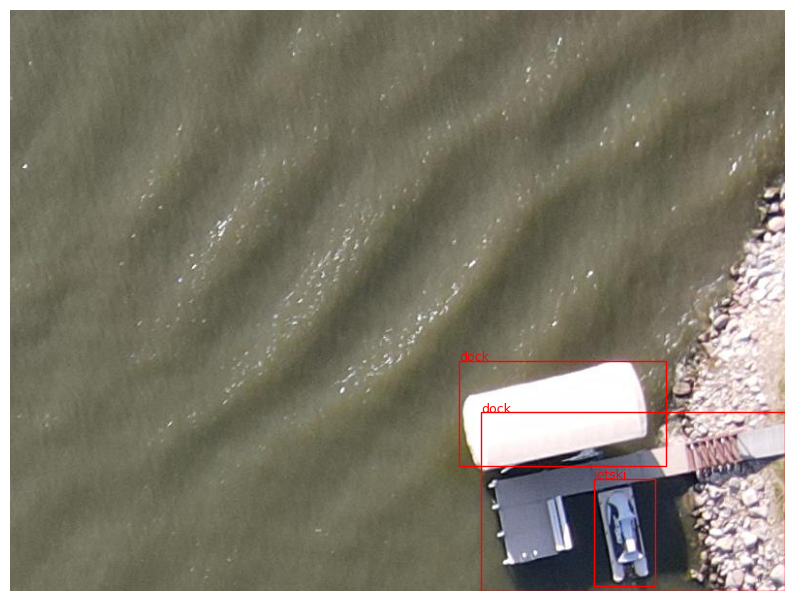

In [7]:
# set the seed for generating random numbers to ensure reproducibility
torch.manual_seed(42)

# generate a random index to select an image from the training dataset
random_idx = torch.randint(0, len(training_dataset) - 1, size = [1]).item()

# retrieve the image and its corresponding target (annotations) at the randomly generated index
img, target = training_dataset[random_idx]

# uncommented to visualize the selected image without annotations
# image_visualization(img)
# additionally, you can load image with readily function in CoCoDetection
# training_dataset._load_image(random_idx)

# ignore the warning message as the image has been transformed for normalization
# visualize the selected image with bounding box annotations
image_visualization_with_annotation(img, target["boxes_for_vis"], target["labels"], 
    catId_to_name_training, format = 'xywh')

#### 2. Model Construction

The Faster R-CNN with ResNet-50 v2 backbone and Feature Pyramid Network (FPN) will be used for object detection tasks. Here's a brief overview of how it's constructed:

1. **Backbone (ResNet-50):** The backbone is responsible for extracting features from the input images. ResNet-50 is a deep residual network with 50 layers. It's pre-trained on ImageNet and used as a feature extractor in the Faster R-CNN model.

2. **Region Proposal Network (RPN):** The RPN takes the output of the backbone and proposes regions (bounding boxes) that might contain objects. It's a fully convolutional network that simultaneously predicts object bounds and objectness scores at each position.

3. **RoI (Region of Interest) Pooling:** The RoI pooling layer takes the proposed regions from the RPN and the feature map from the backbone, and extracts a fixed-length feature vector for each proposed region. This allows the network to perform detection on regions of various sizes.

4. **Detection Head:** The detection head takes the feature vectors from the RoI pooling layer and performs two tasks: it classifies the objects in each proposed region and refines the bounding box coordinates. The classification is done with a softmax over all possible classes, and the bounding box refinement is done with a bounding box regressor.

In [8]:
# set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"The device is: ", device)

# get the number of classes in the training dataset, add 1 for the background class
class_number_plus_background = len(training_dataset.coco.cats) + 1

# set the weights to the default pre-trained weights of the Faster R-CNN ResNet-50 FPN v2 model
# default - COCO_V1
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# initialize the Faster R-CNN ResNet-50 FPN v2 model with the specified weights
model = fasterrcnn_resnet50_fpn_v2(weights = weights)
# model = fasterrcnn_resnet50_fpn(weights = weights)

# get the number of input features for the classifier in the ROI heads of the mode
# then replace the pre-trained box predictor with a new one with the correct number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, class_number_plus_background)

# move model to the right device
model.to(device)

# 1. Step LR
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr = 0.005, momentum = 0.9, weight_decay = 0.0005)
optimizer = torch.optim.SGD(params, lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
# construct a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 3, gamma = 0.1)

# 2. ReduceLROnPlateau
# # construct an optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = 0, weight_decay = 0)
# # construct a learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode = 'min', factor = 0.2, patience = 2, min_lr = 0.001
# )

# enable mixed-precision training
scaler = GradScaler()

model_summary(model, device)

The device is:  cuda


Layer (type (var_name))                            Output Shape              Param #
FasterRCNN (FasterRCNN)                            [100, 4]                  --
├─GeneralizedRCNNTransform (transform)             [1, 3, 800, 800]          --
├─BackboneWithFPN (backbone)                       [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter (body)              [1, 2048, 25, 25]         --
│    │    └─Conv2d (conv1)                         [1, 64, 400, 400]         (9,408)
│    │    └─BatchNorm2d (bn1)                      [1, 64, 400, 400]         (128)
│    │    └─ReLU (relu)                            [1, 64, 400, 400]         --
│    │    └─MaxPool2d (maxpool)                    [1, 64, 200, 200]         --
│    │    └─Sequential (layer1)                    [1, 256, 200, 200]        (215,808)
│    │    └─Sequential (layer2)                    [1, 512, 100, 100]        1,219,584
│    │    └─Sequential (layer3)                    [1, 1024, 50, 50]         7,098,368
│    │

In transfer learning, certain layers of a pre-trained model are often frozen during training to preserve the learned features.

The layers in the beginning of a Convolutional Neural Network (like the layers "backbone.body.layer1" or "backbone.body.layer2" in a ResNet model) typically learn low-level features such as edges, textures and simple shapes. These features are common across many types of images and tasks, it's often beneficial to keep these initial layers frozen, i.e., their weights are not updated during training. In short, early layers of a neural network (closer to the input) capture general features and patterns that are useful across a wide range of tasks.

On the other hand, the later layers (deeper layer which closer to the output) of the network learn high-level features that are more specific to the task the model was originally trained on. These layers are typically unfrozen during transfer learning so that can be fine-tuned to the new task.

Pre-trained model has already learned useful features from a large dataset (like ImageNet, many more), which can provide a good starting point and significantly speed up convergence when training on a new task.

In [ ]:
# uncomment to unfrozen, set all parameters to require gradients to true
# for param in model.parameters():
#     param.requires_grad = True

In [9]:
# check if the parameters are frozen
for name, p in model.named_parameters():
    print(f"{name}: {p.requires_grad}")

backbone.body.conv1.weight: False
backbone.body.bn1.weight: False
backbone.body.bn1.bias: False
backbone.body.layer1.0.conv1.weight: False
backbone.body.layer1.0.bn1.weight: False
backbone.body.layer1.0.bn1.bias: False
backbone.body.layer1.0.conv2.weight: False
backbone.body.layer1.0.bn2.weight: False
backbone.body.layer1.0.bn2.bias: False
backbone.body.layer1.0.conv3.weight: False
backbone.body.layer1.0.bn3.weight: False
backbone.body.layer1.0.bn3.bias: False
backbone.body.layer1.0.downsample.0.weight: False
backbone.body.layer1.0.downsample.1.weight: False
backbone.body.layer1.0.downsample.1.bias: False
backbone.body.layer1.1.conv1.weight: False
backbone.body.layer1.1.bn1.weight: False
backbone.body.layer1.1.bn1.bias: False
backbone.body.layer1.1.conv2.weight: False
backbone.body.layer1.1.bn2.weight: False
backbone.body.layer1.1.bn2.bias: False
backbone.body.layer1.1.conv3.weight: False
backbone.body.layer1.1.bn3.weight: False
backbone.body.layer1.1.bn3.bias: False
backbone.body.laye

#### 3. Model Training/ Evaluation

Through the use of the COCOeval utility, we can calculate the Mean Average Precision (mAP) during the model's evaluation phase. This evaluation can be performed either during or after the training phase of the model. The corresponding code is provided below.

During evaluation phase, informations obtained are mean Average Precision (mAP), Intersection over Union (IoU), and Average Recall (AR). 

Average Precision (AP) measures the precision (proportion of true positive detections) at different recall (proportion of actual positives detected) levels. It's averaged over all categories. In object detection, it usually considers different IoU thresholds.

Average Recall (AR): Similar to AP but focuses on the recall aspect (how many actual positives were detected). Evaluated at different maxDets values to understand model performance under varying detection counts.

<b>mAP @[ IoU=0.50:0.95 | area=all | maxDets=100 ]</b> is the mean AP calculated over IoU thresholds from 0.50 to 0.95, for all areas, considering up to 100 detections per image. In object detection, a higher mAP indicates better performance. The scale is from 0 to 1, with 1 being perfect detection.

In [10]:
# set the number of epochs for training
num_epochs = 5
# define the keys to select from the targets dictionary
selected_keys = ['boxes', 'labels']
# set cpu device for coco evaluation
cpu_device = torch.device("cpu")
# get model iou type
iou_type = get_iou_types(model)[0]
# early stopping initialization
first_early_stopping = FirstEarlyStopping(patience = 5, verbose = True, delta = 0.3)
second_early_stopping = SecondEarlyStopping()
# define if automatic mixed precision training is used
is_automatic_mixed_precision_training = False
# define if gradient accumulation is used
is_gradient_accumulation = False
# define the number of accumulation step
accumulation_step = 5
# initialize best epoch
best_epoch = 0

# training/ validation loss acculumate
result = {
    "total_train_loss": [],
    "total_val_loss": [],
    "total_train_loss_classifier": [],
    "total_val_loss_classifier": [],
    "total_train_loss_box_reg": [],
    "total_val_loss_box_reg": [],
    "total_train_loss_objectness": [],
    "total_val_loss_objectness": [],
    "total_train_loss_rpn_box_reg": [],
    "total_val_loss_rpn_box_reg": []
}

# start the training loop
for epoch in range(num_epochs):
    # set the model to training mode
    # inside epoch loop in the training phase to alternate
    # between training and evaluation modes during each epoch
    model.train()

    # initialize the training loss for this epoch
    train_loss = 0.0
    train_loss_classifier = 0.0
    train_loss_box_reg = 0.0
    train_loss_objectness = 0.0
    train_loss_rpn_box_reg = 0.0

    # iterate over the training data
    for batch_idx, (images, targets) in enumerate(training_dataloader):
        # move the images to the device
        images = list(image.to(device) for image in images)
        # move the targets to the device and select only necessary keys
        targets = [{k: v.to(device) for k, v in t.items() if k in selected_keys} for t in targets]

        # for visualization only, trial and error
        # image_visualization_with_annotation(images[0].cpu(), targets[0]["boxes"].cpu(), targets[0]["labels"].cpu(), catId_to_name_training, format = 'xyxy')
        # image_visualization_with_annotation(images[1].cpu(), targets[1]["boxes"].cpu(), targets[1]["labels"].cpu(), catId_to_name_training, format = 'xyxy')

        if is_automatic_mixed_precision_training:
            # forward pass with autocast for mixed-precision training
            with autocast():
                # perform a forward pass through the model and get the loss
                loss_dict = model(images, targets)
                # calculate the total loss
                loss = sum(loss for loss in loss_dict.values())
        else:
            # perform a forward pass through the model and get the loss
            loss_dict = model(images, targets)
            # calculate the total loss
            loss = sum(loss for loss in loss_dict.values())

        # typically place before backward pass
        # reset the gradients of all optimized variables
        optimizer.zero_grad()

        if is_automatic_mixed_precision_training:
            # if automatic mixed precision (AMP) is used, scale the loss value
            scaler.scale(loss).backward()
            # perform a step of gradient descent on the scaled gradient
            scaler.step(optimizer)
            # update the scale for the next iteration
            scaler.update()

            # if is_gradient_accumulation:
            #     # perform a step of gradient descent on the scaled gradient
            #     scaler.step(optimizer)
            #     # update the scale for the next iteration
            #     scaler.update()
            # else:
            #     # perform a step of gradient descent on the scaled gradient
            #     scaler.step(optimizer)
            #     # update the scale for the next iteration
            #     scaler.update()
        else:
            # compute the gradient for each variable in the loss function
            loss.backward()
            # perform a step of gradient descent
            optimizer.step()

            # if is_gradient_accumulation:
            #     # perform a step of gradient descent
            #     optimizer.step()
            # else:
            #     # perform a step of gradient descent
            #     optimizer.step()

        # add the loss of this batch to the total training loss
        train_loss += loss.item()
        train_loss_classifier += loss_dict["loss_classifier"].item()
        train_loss_box_reg += loss_dict["loss_box_reg"].item()
        train_loss_objectness += loss_dict["loss_objectness"].item()
        train_loss_rpn_box_reg += loss_dict["loss_rpn_box_reg"].item()

        # delete tensor and clear cache to free up memory
        del images, targets, loss_dict
        # clear system memory
        gc.collect()

    # clear cache after each epoch
    torch.cuda.empty_cache()
    # clear system memory
    gc.collect()

    # append the loss of this batch to the result dictionary
    result["total_train_loss"].append((train_loss / len(training_dataloader)))
    result["total_train_loss_classifier"].append((train_loss_classifier / len(training_dataloader)))
    result["total_train_loss_box_reg"].append((train_loss_box_reg / len(training_dataloader)))
    result["total_train_loss_objectness"].append((train_loss_objectness / len(training_dataloader)))
    result["total_train_loss_rpn_box_reg"].append((train_loss_rpn_box_reg / len(training_dataloader)))

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss / len(training_dataloader)}')

    # update the learning rate scheduler
    lr_scheduler.step()

    # create check point after each epoch
    # saving checkpoint for for resuming training
    # can load for inference
    checkpoint = {
        "model": model.state_dict(),
        "optimizer": optimizer.state_dict(),
        "lr_scheduler": lr_scheduler.state_dict(),
        "epoch": epoch,
    }

    torch.save(checkpoint, f"checkpoint/checkpoint-{epoch + 1}.pth")

    # validation_loss, detections = evaluation_loss_map(model, validation_dataloader, selected_keys, device, iou_type, cpu_device)
    val_loss_result = evaluation_loss_map(epoch, num_epochs, model, validation_dataset, validation_dataloader, 
        selected_keys, device, iou_type, cpu_device, catId_to_name_validation)

    # collect data
    total_val_loss = val_loss_result[0]
    total_val_loss_classifier = val_loss_result[1]
    total_val_loss_box_reg = val_loss_result[2]
    total_val_loss_objectness = val_loss_result[3]
    total_val_loss_rpn_box_reg = val_loss_result[4]
    custom_map_result = val_loss_result[5]

    result["total_val_loss"].append(total_val_loss)
    result["total_val_loss_classifier"].append(total_val_loss_classifier)
    result["total_val_loss_box_reg"].append(total_val_loss_box_reg)
    result["total_val_loss_objectness"].append(total_val_loss_objectness)
    result["total_val_loss_rpn_box_reg"].append(total_val_loss_rpn_box_reg)

    # ReduceLROnPlateau implementation
    # update the learning rate scheduler
    # lr_scheduler.step(total_val_loss)

    # implement early stopping here
    # first_early_stopping(total_val_loss)

    # if first_early_stopping.early_stop:
    #     print(f"epoch break at {epoch + 1} due to early stopping")
    #     break

    if second_early_stopping(epoch, custom_map_result['fitness']):
        best_epoch = second_early_stopping.best_epoch
        break

    # comment for implement validation map every epoch 
    continue

    # set the model to evaluation mode
    model.eval()

    # disable gradient calculation for performance
    with torch.no_grad():
        # initialize COCO evaluation
        eval = COCOeval(validation_dataset, iouType = iou_type)
        # initialize list to store image id and evaluation image
        img_ids_list = []
        eval_imgs_collection = []

        for batch_idx, (images, targets) in enumerate(validation_dataloader):
            images = list(image.to(device) for image in images)
            outputs = model(images)
            outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

            # create a dictionary mapping image id to output
            res = {target["image_id"]: output for target, output in zip(targets, outputs)}

            # get unique image id then extend to the list
            unique_img_ids = list(np.unique(list(res.keys())))
            img_ids_list.extend(unique_img_ids)

            # prepare/ convert the result for COCO detection
            # mainly convert from (x1, y1, x2, y2) to (x, y, width, height) format
            coco_res = prepare_for_coco_detection(res)

            # load the result into a COCO object
            with redirect_stdout(io.StringIO()):
                coco_dt = COCO.loadRes(validation_dataset, coco_res) if coco_res else COCO()

            # set the COCO object and image id for the evaluation
            eval.cocoDt = coco_dt
            eval.params.imgIds = list(unique_img_ids)

            # start coco evaluation
            # reshape eval_img to shape based on (category_id, areaRng (object area range), image_id (batch))
            img_ids, eval_imgs = evaluate(eval)

            # append the evaluation image to the collection
            eval_imgs_collection.append(eval_imgs)

        # concatenating all the array in the list along the third axis
        conc_eval_imgs_collection = np.concatenate(eval_imgs_collection, 2)

        # keep only unique (and in sorted order) image
        merged_img_ids, idx = np.unique(img_ids_list, return_index = True)
        merged_eval_imgs = conc_eval_imgs_collection[..., idx]

        # convert the merged image id and evaluation image to list
        img_ids = list(merged_img_ids)
        eval_imgs = list(merged_eval_imgs.flatten())

        # set the evaluation image and image id for the evaluation
        eval.evalImgs = eval_imgs
        eval.params.imgIds = img_ids
        eval._paramsEval = copy.deepcopy(eval.params)

        # accumulate the evaluation result
        eval.accumulate()
        # summarize the evaluation result
        eval.summarize()

Epoch 1/5, Training Loss: 0.7140758301450236
Epoch 1/5, Validation Loss: 0.5065081481422696
Epoch 1/5, Class: all, Total image: 105, Instance: 265, metrics/precision(B): 0.8165989371323882, metrics/recall(B): 0.22244150700186482, metrics/mAP50(B): 0.2722061791497078, metrics/mAP50-95(B): 0.1389029068112592
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.212
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.413
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.213
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.068
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.254
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.346
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.494
 

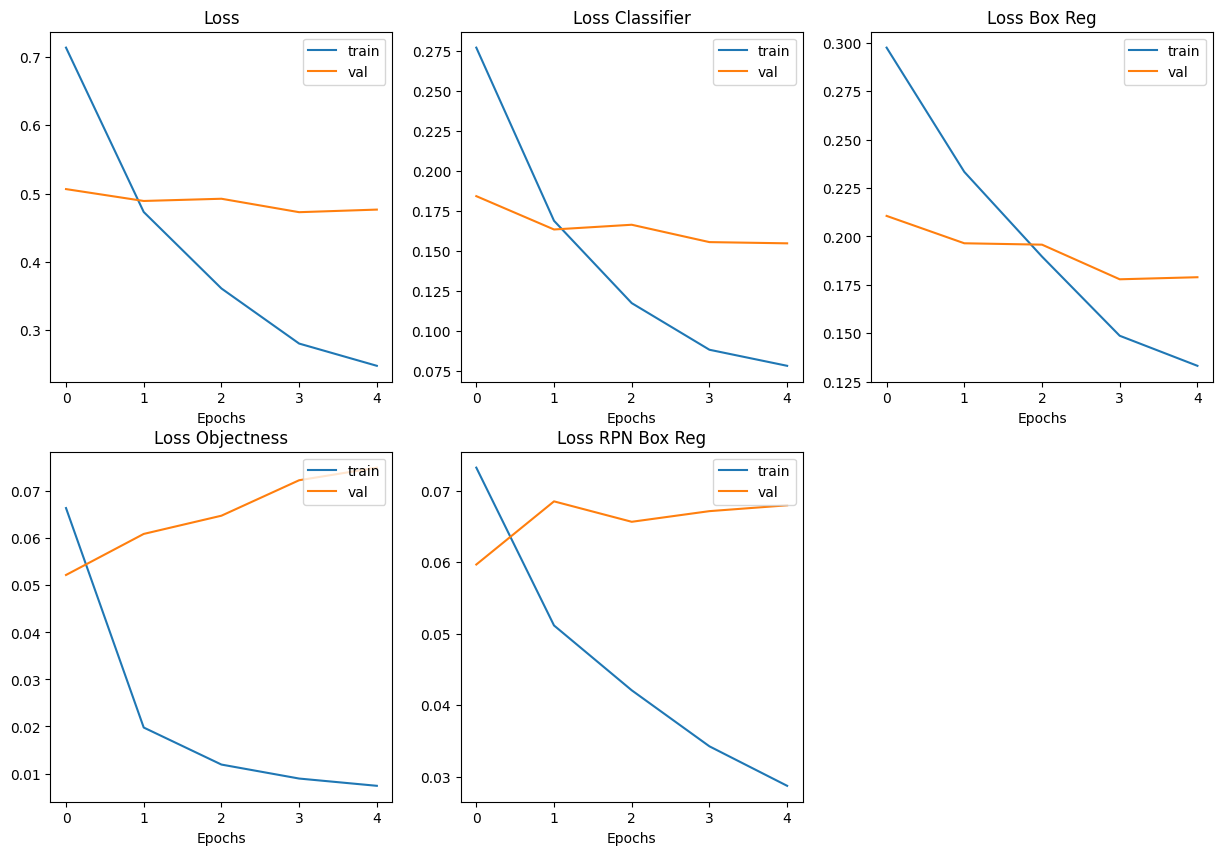

In [11]:
# plotting the loss curve
now = datetime.now()
dir_name = now.strftime("%Y-%m-%d_%H-%M-%S")

plot_loss_curve(result, dir_name)

In [12]:
# implement if early stopping is used
if best_epoch != 0:
    print("best epoch: ", best_epoch)

    # get/ load the best model based on epoch
    checkpoint = torch.load("checkpoint/checkpoint-{}.pth".format(best_epoch))
    model.load_state_dict(checkpoint['model'])

In [13]:
# model evaluation without training loop
# set the model to evaluation mode
model.eval()

# initialize COCO evaluation
eval = COCOeval(validation_dataset, iouType = iou_type)

# initialize list to store image id and evaluation image
img_ids_list = []
eval_imgs_collection = []

# iou vector for mAP@0.5:0.95 and its count
# iou_vector = torch.linspace(0.5, 0.95, 10, device = device)
iou_vector = torch.linspace(0.5, 0.95, 10)
iou_count = iou_vector.numel()

# variable for evaluation
stats = []
class_number = class_number_plus_background - 1
confusion_matrix = ConfusionMatrix(class_number = class_number, confident_score = 0.5, iou_threshold = 0.5)
save_dir = Path(f"result/{dir_name}")

# disable gradient calculation for performance
with torch.no_grad():
    for batch_idx, (images, targets) in enumerate(validation_dataloader):
        images = list(image.to(device) for image in images)
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        # outputs = [{k: v for k, v in t.items()} for t in outputs]

        for index, output in enumerate(outputs):
            pred_box = output['boxes']
            pred_label = output['labels']
            pred_score = output['scores']

            # apply nms to filter out overlapping prediction
            iou_threshold = 0.5
            keep = nms(pred_box, pred_score, iou_threshold)
            kept_label = pred_label[keep]
            kept_box = pred_box[keep]
            kept_score = pred_score[keep]

            # label = torch.cat((targets[index]["labels"].unsqueeze(1), targets[index]["boxes"]), dim = 1).to(device)
            label = torch.cat((targets[index]["labels"].unsqueeze(1), targets[index]["boxes"]), dim = 1)

            # number of label, prediction
            label_number, prediction_number = label.shape[0], pred_label.shape[0]
            # correct = torch.zeros(prediction_number, iou_count, dtype = torch.bool, device = device)
            correct = torch.zeros(prediction_number, iou_count, dtype = torch.bool)

            if prediction_number == 0:
                if label_number:
                    # stats.append((correct, *torch.zeros((2, 0), device = device), label[:, 0]))
                    stats.append((correct, *torch.zeros((2, 0)), label[:, 0]))
                    confusion_matrix.process_batch(detection = None, label = label[:, 0])

            if label_number:
                prediction = torch.cat((kept_box, kept_score.unsqueeze(1), kept_label.unsqueeze(1)), dim = 1)
                correct = correct_process_batch(prediction, label, iou_vector)
                confusion_matrix.process_batch(prediction, label)

            # appending (correct, confidence score, predicted class, ground truth class)
            stats.append((correct, prediction[:, 4], prediction[:, 5], label[:, 0]))

        # create a dictionary mapping image id to output
        res = {target["image_id"]: output for target, output in zip(targets, outputs)}

        # get unique image id then extend to the list
        unique_img_ids = list(np.unique(list(res.keys())))
        img_ids_list.extend(unique_img_ids)

        # prepare/ convert the result for COCO detection
        # mainly convert from (x1, y1, x2, y2) to (x, y, width, height) format
        coco_res = prepare_for_coco_detection(res)

        # load the result into a COCO object
        with redirect_stdout(io.StringIO()):
            coco_dt = COCO.loadRes(validation_dataset, coco_res) if coco_res else COCO()

        # set the COCO object and image id for the evaluation
        eval.cocoDt = coco_dt
        eval.params.imgIds = list(unique_img_ids)

        # start coco evaluation
        # reshape eval_img to shape based on (category_id, areaRng (object area range), image_id (batch))
        img_ids, eval_imgs = evaluate(eval)

        # append the evaluation image to the collection
        eval_imgs_collection.append(eval_imgs)

    # compute metric & convert to numpy
    stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]

    if len(stats) and stats[0].any():
        tp, fp, p, r, f1, ap, ap_class, *_ = ap_per_class(*stats, plot = True, 
            save_dir = save_dir, names = catId_to_name_validation, on_plot = None)
        # ap@0.5, ap@0.5:0.95
        ap50, ap = ap[:, 0], ap.mean(1)
        mp, mr, map50, map = p.mean(), r.mean(), ap50.mean(), ap.mean()

    # number of target per class
    nt = np.bincount(stats[3].astype(int), minlength = class_number)

    # print result
    print(f"class - all, p: {mp}, r : {mr}, mAP50: {map50}, mAP50-95: {map}")

    if nt.sum() == 0:
        print(f"no label found, can not compute metrics without label")

    # plot confusion matrix
    confusion_matrix.plot(save_dir = save_dir, normalize = True, names = list(catId_to_name_validation.values()))
    confusion_matrix.plot(save_dir = save_dir, normalize = False, names = list(catId_to_name_validation.values()))

    # concatenating all the array in the list along the third axis
    conc_eval_imgs_collection = np.concatenate(eval_imgs_collection, 2)

    # keep only unique (and in sorted order) image
    merged_img_ids, idx = np.unique(img_ids_list, return_index = True)
    merged_eval_imgs = conc_eval_imgs_collection[..., idx]

    # convert the merged image id and evaluation image to list
    img_ids = list(merged_img_ids)
    eval_imgs = list(merged_eval_imgs.flatten())

    # set the evaluation image and image id for the evaluation
    eval.evalImgs = eval_imgs
    eval.params.imgIds = img_ids
    eval._paramsEval = copy.deepcopy(eval.params)

    # accumulate the evaluation result
    eval.accumulate()
    # summarize the evaluation result
    eval.summarize()

class - all, p: 0.45717625577145443, r : 0.3982504383867368, mAP50: 0.4170528435856859, mAP50-95: 0.23462648936783398
Accumulating evaluation results...
DONE (t=0.03s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.505
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.145
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.312
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.348
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.459
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU

Both `torch.no_grad()` and `torch.inference_mode()` are context-managers that disable gradient calculation. However, they have different use-cases and behaviors:

1. `torch.no_grad()`: Disables gradient calculation, but does not have any effect on other operations. This is useful when need to perform operations that do not require gradients, such as evaluating a model.

2. `torch.inference_mode()`: Introduced in PyTorch 1.9.0, this not only disables gradient calculation, but also disables other computations that are unnecessary for inference, potentially leading to significant speed improvements. However, it should be used with caution, as certain operations (like in-place operations) can behave differently under `torch.inference_mode()`.

In general, if just doing evaluation and don't care about gradients, can use `torch.no_grad()`. If doing inference and want to optimize for speed, can try using `torch.inference_mode()`. Kindly be aware of its potential side effects.

Image shape: (600, 800, 3)
[{'boxes': tensor([[258.7826, 161.4338, 413.4426, 325.5775],
        [233.4637, 259.8955, 372.1317, 462.1635],
        [265.4466, 156.6606, 392.4662, 320.7003],
        [240.6974, 252.1516, 371.3762, 362.2911],
        [229.5406, 131.8901, 418.6138, 470.8725]]), 'labels': tensor([3, 3, 5, 3, 3]), 'scores': tensor([0.9479, 0.6174, 0.2943, 0.1415, 0.0810])}]


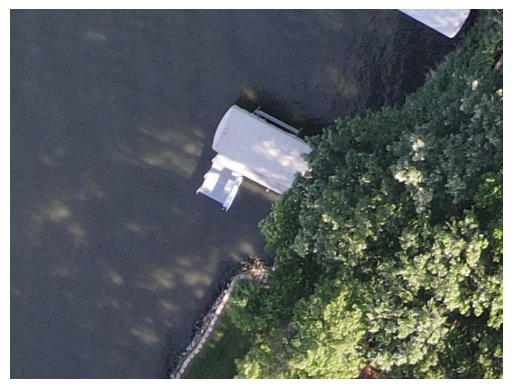

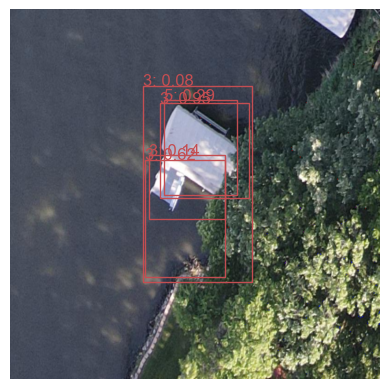

In [14]:
resize_transform = v2.Compose([
  v2.ToImage(),
  v2.ToDtype(torch.uint8, scale = True),
  v2.Resize((640, 640), antialias = True),
  # v2.ToTensor(), # DEPRECATED
  v2.ToDtype(torch.float32, scale = True),
  # v2.Normalize(
  #     mean = [0.485, 0.456, 0.406],
  #     std = [0.229, 0.224, 0.225]
  # ),
])

random_train_image = select_and_view_random_image(
  target_dir = "../../../dataset/aerial_maritime/test", 
  target_class = "/images/"
)

train_image = Image.fromarray((random_train_image * 255).astype(np.uint8))
train_image = resize_transform(train_image)
train_image = train_image.unsqueeze(0)

model.to(cpu_device)

model.eval()

with torch.inference_mode():
    output = model(train_image)
    print(output)
    visualize_output(train_image, output)

#### 4. Model Export

The model will be made available for export in several formats, including PyTorch, ONNX, OpenVino, and TensorRT.

4.1 Export model as PyTorch

In [15]:
# saves only the model's parameters (weights and biases) in a dictionary
# recommaded for saving PyTorch model, allow for maximum flexibility and portability
torch.save(model.state_dict(), 'model/resnet50v2-1.pth')

# save entire model, including its architecture, parameters, and optimizer state
# not recommended because it uses Python pickling and 
# can lead to issues when the saved model is loaded in a different environment
torch.save(model, 'model/resnet50v2-2.pth')

# export model in TorchScript format
# run independently of the Python runtime, and then save it
# useful when deploy model in non-python environment
# also want to optimize model for performance
model_scripted = torch.jit.script(model)
model_scripted.save('model/resnet50v2-3.pth')

4.2 Export model as ONNX

In [16]:
# initialize input size for onnx model
input_tensor = torch.randn(1, 3, 640, 640)

torch.onnx.export(model, input_tensor, "model/resnet50v2.onnx", verbose = True)

c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\torch\nn\functional.py:3964: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  (torch.floor((input.size(i + 2).float() * torch.tensor(scale_factors[i], dtype=torch.float32)).float()))
c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\torchvision\ops\boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\torchvision\ops\boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor

4.3 Export model to OpenVINO

`fasterrcnn_resnet50_fpn_v2` is failed to be converted and exported due to `torchvision.models.resnet50` and `fasterrcnn_resnet50_fpn_v2` models are fundamentally different in their structure and operation.

`torchvision.models.resnet50` is a classification model and is a straightforward operation that can be easily represented in OpenVINO. On the other hand, `fasterrcnn_resnet50_fpn_v2` is an object detection model. It not only classifies objects in an image but also provides their bounding boxes. This involves operations like non-maximum suppression and RoI (Region of Interest) pooling, which are not standard operations and may not be supported in OpenVINO.

Convert `fasterrcnn_resnet50_fpn_v2` to OpenVINO, these non-standard operations can cause problems. Some of these operations might not be supported in OpenVINO, or they might be supported but not correctly converted.

If need to use `fasterrcnn_resnet50_fpn_v2` in OpenVINO, might need to modify the model to replace the non-standard operations with standard operations that are supported in OpenVINO. Alternatively, might need to implement these operations in OpenVINO. 

Solution now, use `torch.onnx.export` to export the model to ONNX format, which is a more straightforward process as OpenVINO framework can read ONNX file. 

In [17]:
# convert model to openvino
# channel_number, height, width = 3, 640, 640
# example_input = torch.randn((batch_size, channel_number, height, width))

# model = torchvision.models.resnet50(weights = 'DEFAULT')
# ov_model = ov.convert_model(model, example_input = example_input)
# ov.save_model(ov_model, "model/resnet50v2.xml") 

4.4 Export model as TensorRT

Problem also occurs when export to TensorRT. Use `torch.onnx.export` to export the model to ONNX format, which is a more straightforward process as TensorRT framework can read ONNX file too. 

In [18]:
TRT_LOGGER = trt.Logger(trt.Logger.WARNING)

# create a TensorRT builder, network, and parser
builder = trt.Builder(TRT_LOGGER)
network = builder.create_network(1 << int(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH))
parser = trt.OnnxParser(network, TRT_LOGGER)

# parse the ONNX model
with open("model/resnet50v2.onnx", "rb") as model_file:
    if not parser.parse(model_file.read()):
        print("ERROR: Failed to parse the ONNX file.")
        for error in range(parser.num_errors):
            print(parser.get_error(error))
        sys.exit(1)

# build TensorRT engine
builder.max_batch_size = 1
config = builder.create_builder_config()
config.max_workspace_size = 1 << 30  # this is 1GB
engine = builder.build_engine(network, config)

# save the engine
trt_model_path = "model/faster_rcnn.trt"
with open(trt_model_path, "wb") as f:
    f.write(engine.serialize())

ERROR: Failed to parse the ONNX file.
In node 1424 (importSlice): UNSUPPORTED_NODE: Assertion failed: (axes.allValuesKnown()) && "This version of TensorRT does not support dynamic axes."


SystemExit: 1

c:\Users\christopher_hu\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\IPython\core\interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
